## Play Cart-Pole Game using Deep Q-learning
Using Q-learning to train an agent to play a game called Cart-Pole. In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Create Cart-Pole game environment
env = gym.make("CartPole-v0")

[2017-10-11 10:07:20,679] Making new env: CartPole-v0


## Q-Network

Train Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, there are infinite states. Instead of using a table then, a neural network will approximate the Q-table lookup function.The weights will be updated by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 


<img src="assets/q-network.png" width=550px>


To reduce correlations when training,the agent's experiences will be stored and later a random mini-batch of those experiences to train on will be drawn. Here, a `Memory` object that stores  experiences, transitions $<s, a, r, s'>$, will be created. This memory will have a maxmium capacity, so the agnet can keep newer experiences while getting rid of older experiences. Then, the agent samples a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. So to choose a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.

## Q-Learning training algorithm

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

In [3]:
class QNetwork(object):
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10):
        self.inputs_ = tf.placeholder(shape=[None, state_size], dtype=tf.float32, name="inputs")
        self.targetQs_ = tf.placeholder(shape=[None], dtype=tf.float32, name="targetQs")
        self.actions_ = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
        
        self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, activation_fn=tf.nn.relu)
        self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, activation_fn=tf.nn.relu)
        self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
        
        one_hot_actions = tf.one_hot(self.actions_, action_size)
        self.Qs = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
        self.loss = tf.reduce_mean(tf.square(self.Qs - self.targetQs_))
        
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)        

In [4]:
import collections
class Memory(object):
    def __init__(self, max_size=100):
        self.buffer = collections.deque(maxlen=max_size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        slices = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace = False)
        return [self.buffer[i] for i in slices]

In [5]:
# Hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
# Initialize the experience memory
memory = Memory(memory_size)
env.reset()
# Take one random step to start the game
state, reward, done, _ = env.step(env.action_space.sample())
for _ in range(pretrain_length):
    action = env.action_space.sample()
    prev_state = state
    state, reward, done, _ = env.step(action)
    if done:
        state = np.zeros(state.shape)
        experience = [prev_state, action, reward, state]
        memory.add(experience)
        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        experience = [prev_state, action, reward, state]
        memory.add(experience)

In [7]:
# Train the network with experiences
QN = QNetwork(learning_rate=learning_rate, hidden_size=hidden_size)
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    t=0
    for e in range(train_episodes):
        step = 0
        total_reward = 0
        loss = 0
        while step<max_steps:
            step += 1;
            t += 1
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*t) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                output = sess.run(QN.output, feed_dict={QN.inputs_:state.reshape((1,*state.shape))})
                assert output.shape==(1,2)
                action = np.argmax(output)
            
            prev_state = state
            # Take action
            state, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Update the experience mempry
            if done:
                state = np.zeros(state.shape)
                experience = [prev_state, action, reward, state]
                memory.add(experience)
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
                step = max_steps
            else:
                experience = [prev_state, action, reward, state]
                memory.add(experience)
                
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_states = np.array([ee[0] for ee in batch])
            actions = np.array([ee[1] for ee in batch])
            rewards = np.array([ee[2] for ee in batch])
            states = np.array([ee[3] for ee in batch])
            
            # Train 
             # Calculate Q of next_step
            next_Qs = sess.run(QN.output, feed_dict={QN.inputs_:states})
            ends = (states==np.zeros(states[0].shape)).all(axis=1)
            next_Qs[ends] = [0,0]
            
            target_Qs = rewards + gamma * np.max(next_Qs, axis=1)
            
            loss, _ = sess.run([QN.loss, QN.opt], 
                               feed_dict={QN.inputs_:prev_states, QN.targetQs_:target_Qs, QN.actions_:actions})
            
        rewards_list.append(total_reward)
        print('Episode: {}'.format(e+1),
              'Total reward: {}'.format(total_reward),
              'Training loss: {:.4f}'.format(loss),
              'Explore P: {:.4f}'.format(explore_p))
    saver.save(sess, "cartpole_checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 1.0 Training loss: 1.2343 Explore P: 0.9999
Episode: 2 Total reward: 21.0 Training loss: 1.1027 Explore P: 0.9978
Episode: 3 Total reward: 10.0 Training loss: 1.1792 Explore P: 0.9968
Episode: 4 Total reward: 25.0 Training loss: 1.0491 Explore P: 0.9944
Episode: 5 Total reward: 13.0 Training loss: 1.0051 Explore P: 0.9931
Episode: 6 Total reward: 24.0 Training loss: 1.0119 Explore P: 0.9907
Episode: 7 Total reward: 10.0 Training loss: 1.0361 Explore P: 0.9898
Episode: 8 Total reward: 14.0 Training loss: 1.0504 Explore P: 0.9884
Episode: 9 Total reward: 16.0 Training loss: 1.0759 Explore P: 0.9868
Episode: 10 Total reward: 27.0 Training loss: 1.0897 Explore P: 0.9842
Episode: 11 Total reward: 11.0 Training loss: 1.0946 Explore P: 0.9831
Episode: 12 Total reward: 19.0 Training loss: 1.1288 Explore P: 0.9813
Episode: 13 Total reward: 17.0 Training loss: 1.1233 Explore P: 0.9796
Episode: 14 Total reward: 22.0 Training loss: 1.1350 Explore P: 0.9775
Episode: 15 Tota

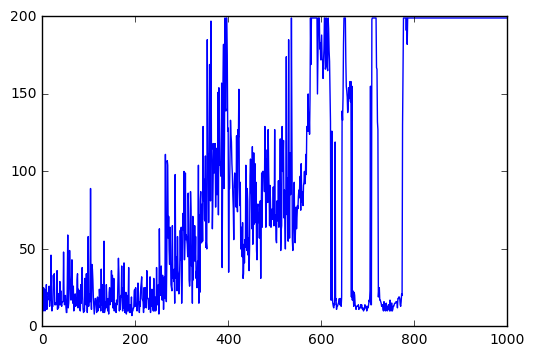

In [8]:
plt.plot(rewards_list)

In [13]:
# Testing
test_episodes = 10
test_max_steps = 400
env.reset()
# Take one random step to start the game
state, reward, done, _ = env.step(env.action_space.sample())
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint("cartpole_checkpoints"))  
    for e in range(test_episodes):
        step = 0
        total_reward = 0
        while step < test_max_steps:
            env.render()
            step += 1
            
            # Get action from Q-network
            output = sess.run(QN.output, feed_dict={QN.inputs_:state.reshape((1,*state.shape))})
            action = np.argmax(output)
            
            # Take action
            prev_state = state
            state, reward, done, info = env.step(action)
            total_reward += reward
            
            if done:
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
                print(step)
                step = test_max_steps
        
        print('Episode: {}'.format(e+1),
              'Total reward: {}'.format(total_reward))

INFO:tensorflow:Restoring parameters from cartpole_checkpoints\cartpole.ckpt


[2017-10-11 10:14:14,861] Restoring parameters from cartpole_checkpoints\cartpole.ckpt


199
Episode: 1 Total reward: 199.0
199
Episode: 2 Total reward: 199.0
199
Episode: 3 Total reward: 199.0
199
Episode: 4 Total reward: 199.0
199
Episode: 5 Total reward: 199.0
199
Episode: 6 Total reward: 199.0
199
Episode: 7 Total reward: 199.0
199
Episode: 8 Total reward: 199.0
199
Episode: 9 Total reward: 199.0
199
Episode: 10 Total reward: 199.0


In [12]:
env.close()